In [1]:
import os
os.chdir('../')
from helpers import *

mousenums:  ['230', '355', '358', '362', '673', '674', '816', '825']


In [2]:
mousenums = ['230', '355', '362', '673', '674', '816', '825']

In [3]:
# epm+rat
timeBefore = 40
timeAfter = 40

mousenums = ['230', '355', '362', '673', '674', '816', '825']

behavtraces = []
ctab = []
for b, behavFrame in enumerate(['approachFrameMS', 'stretchFrameMS', 'escapeFrameMS', 'freezeFrameMS']):
    traces = []
    ctab.append([])
    for mouse in mousenums:
        try:
            track1, neur1, behav1 = getdicts(foldnames, mouse, 'epm')
            track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
            rvel = track2['ratVelMS'].flatten()
            calc1, calc2 = getcalcs(foldnames, mouse, 'epm', 'rat1')
            calc2 = zscore(calc2)
            
            mpos2 = track2['mouse_positionMS']
            mpos2[:, 0] = minmaxscale(mpos2[:, 0], 0, 70, np.max(track2['rat_positionMS'][:, 0]))
            
            speed = track2['mouseVelMS'].flatten()

            starttimes = []
            endtimes = []
            for starttime, endtime in zip(behav2[behavFrame][:, 0], behav2[behavFrame][:, 1]):
                if starttime > timeBefore and calc2.shape[0] - starttime > timeAfter:
                    starttimes.append(starttime)
                    endtimes.append(endtime)
            starttimes = np.array(starttimes)
            endtimes = np.array(endtimes)
            
            if len(starttimes) < 10:
                continue
            
            for cell in range(calc2.shape[1]):
                trace = np.zeros((starttimes.size, timeBefore+timeAfter))
                ctype = celltypebehav(calc1[:, cell], behav1)
                for k, starttime in enumerate(starttimes):
                    endtime = endtimes[k]
                    trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
                    
                traces.append(np.mean(trace, axis=0))
                ctab[-1].append(ctype)
        except:
            print(behavFrame, mouse, 'no instances')
            pass
    traces = np.array(traces)
    behavtraces.append(traces)
ctab1 = ctab
behavtraces1 = behavtraces

freezeFrameMS 230 no instances


In [4]:
timeBefore = 40
timeAfter = 40

ctypes = []
armscores = []
traces = []
for mouse in mousenums:
    track1, neur1, behav1 = getdicts(foldnames, mouse, 'epm')
    track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
    rvel = track2['ratVelMS'].flatten()
    calc1, calc2 = getcalcs(foldnames, mouse, 'epm', 'rat1')
    calc1 = zscore(calc1)
    calc2 = zscore(calc2)
    
    for cell in range(calc1.shape[1]):
        ctypes.append(celltypebehav(calc1[:, cell], behav1))
        armscores.append(armscorebehav(calc1[:, cell], behav1))
    
    threshold = np.percentile(rvel, 99.5)
    T = rvel.shape[0]
    starttimes = []
    lasttime = 0
    timediff = 40
    for t in range(timeBefore, T - timeAfter):
        if rvel[t] > threshold:
            if t - lasttime > timediff:
                starttimes.append(t)
            lasttime = t
    starttimes = np.array(starttimes)
    
    for cell in range(calc1.shape[1]):
        trace = np.zeros((starttimes.size, timeBefore+timeAfter))
        for k, starttime in enumerate(starttimes):
            trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
        traces.append(np.mean(trace, axis=0))
ctypes = np.array(ctypes)
armscores = np.array(armscores)
traces = np.array(traces)

In [5]:
behavtraces[1] = traces
ctab1[1] = ctab1[0]

In [6]:
colors = ['r', 'k', 'b']
behavs = ['approach', 'rat movement', 'escape', 'freeze']

approach RanksumsResult(statistic=2.4475556345856604, pvalue=0.014382891830358062)
rat movement RanksumsResult(statistic=-3.7014572135349297, pvalue=0.0002143648077140735)
escape RanksumsResult(statistic=-2.161379898849491, pvalue=0.03066600554856357)
freeze RanksumsResult(statistic=-3.7978027674967354, pvalue=0.00014598440828556938)


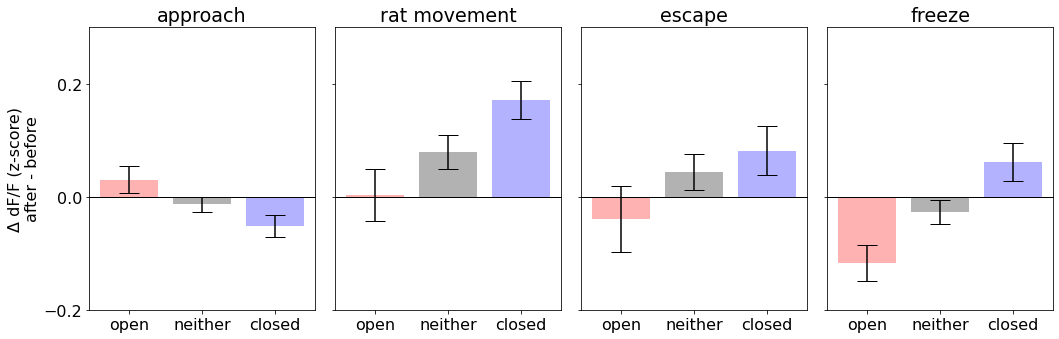

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
for i in range(4):
    plt.sca(ax[i])
    diffs = []
    for j, typ in enumerate(['o', 'n', 'c']):
        cta = np.array(ctab[i])
        diff = np.mean(behavtraces[i][cta==typ, 40:59], axis = 1) - np.mean(behavtraces[i][cta==typ, 21:40], axis = 1)
        diffs.append(diff)
        plt.bar(j, np.mean(diff), color=colors[j], alpha=0.3)
        plt.errorbar(j, np.mean(diff), sem(diff), fmt='k_', ms=0, capsize=10)
    print(behavs[i], ranksums(diffs[0], diffs[2]))
    plt.xticks([0, 1, 2], ['open', 'neither', 'closed'])
    plt.title(behavs[i])
    plt.plot(0, 0, 'k_', ms=2000)
plt.sca(ax[0])
plt.ylabel('Δ dF/F (z-score)\nafter - before')
plt.yticks([-0.2, 0, 0.2])
plt.ylim(-0.2, 0.3)
plt.tight_layout()

plt.savefig('./elife_figs/3J.svg')

In [8]:
t = np.arange(-40, 40)/7.5

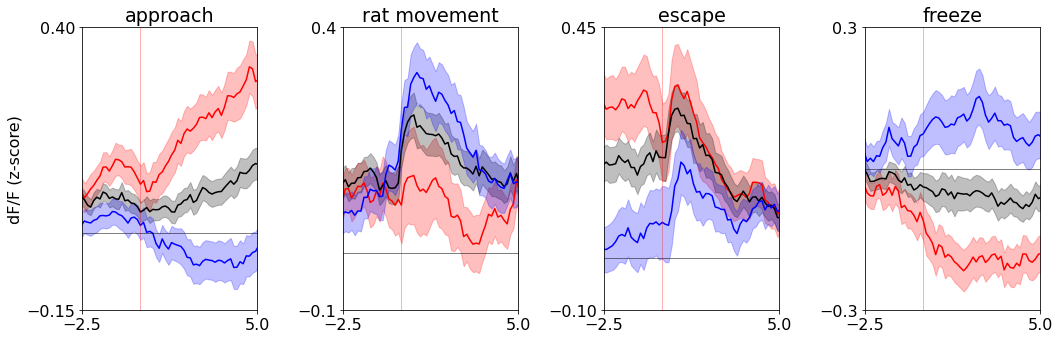

In [9]:
plt.figure(figsize=(15, 5))
ylims = [(-0.15, 0.4), (-0.1, 0.4), (-0.1, 0.45), (-0.3, 0.3)]
yticks = ylims
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.ylabel('dF/F (z-score)')
    for j, typ in enumerate(['o', 'n', 'c']):
        cta = np.array(ctab1[i])
        data = behavtraces1[i][cta==typ]
        tracemu = np.mean(data, axis=0)
        tracesem = sem(data, axis=0)
        plt.fill_between(t, tracemu-tracesem, tracemu+tracesem, alpha=0.25, color=colors[j])
        plt.plot(t, tracemu, color=colors[j])
    
    plt.title(behavs[i])
    plt.xlim(-2.5, 5)
    plt.xticks([-2.5, 5])
    plt.plot(0, 0, 'r|', ms=2000, alpha=0.3)
    plt.plot(0, 0, 'k_', ms=2000, alpha=0.5)
    plt.ylim(*ylims[i])
    plt.yticks(yticks[i])

plt.ylim()
plt.tight_layout()

plt.savefig('./elife_figs/3I.svg')

In [10]:
# use this one i think
# rat only
timeBefore = 40
timeAfter = 40

mousenums = ['230', '355', '362', '673', '674', '816', '825']

behavtraces = []
for b, behavFrame in enumerate(['approachFrameMS', 'stretchFrameMS', 'escapeFrameMS', 'freezeFrameMS']):
    traces = []
    ctab.append([])
    for mouse in mousenums:
        try:
            track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
            rvel = track2['ratVelMS'].flatten()
            calc2 = getcalc(foldnames, mouse, 'rat1')
            calc2 = zscore(calc2)
            
            mpos2 = track2['mouse_positionMS']
            mpos2[:, 0] = minmaxscale(mpos2[:, 0], 0, 70, np.max(track2['rat_positionMS'][:, 0]))
            
            speed = track2['mouseVelMS'].flatten()

            starttimes = []
            endtimes = []
            for starttime, endtime in zip(behav2[behavFrame][:, 0], behav2[behavFrame][:, 1]):
                if starttime > timeBefore and calc2.shape[0] - starttime > timeAfter:
                    starttimes.append(starttime)
                    endtimes.append(endtime)
            starttimes = np.array(starttimes)
            endtimes = np.array(endtimes)
            
            #if len(starttimes) < 10:
            #    print(mouse, behavFrame, '<10')
            #    continue
            
            for cell in range(calc2.shape[1]):
                trace = np.zeros((starttimes.size, timeBefore+timeAfter))
                for k, starttime in enumerate(starttimes):
                    endtime = endtimes[k]
                    trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
                    
                traces.append(np.mean(trace, axis=0))
        except:
            print(behavFrame, mouse, 'no instances')
            pass
    traces = np.array(traces)
    behavtraces.append(traces)
behavtraces2 = behavtraces

freezeFrameMS 230 no instances


In [11]:
# rat only
timeBefore = 40
timeAfter = 40

rmovetraces = []
for mouse in mousenums:
    track2, neur2, behav2 = getdicts(foldnames, mouse, 'rat1')
    rvel = track2['ratVelMS'].flatten()
    calc2 = getcalc(foldnames, mouse, 'rat1')
    calc2 = zscore(calc2)
    
    threshold = np.percentile(rvel, 99.5)
    T = rvel.shape[0]
    starttimes = []
    lasttime = 0
    timediff = 40
    for t in range(timeBefore, T - timeAfter):
        if rvel[t] > threshold:
            if t - lasttime > timediff:
                starttimes.append(t)
            lasttime = t
    starttimes = np.array(starttimes)
    
    
    for cell in range(calc2.shape[1]):
        trace = np.zeros((starttimes.size, timeBefore+timeAfter))
        for k, starttime in enumerate(starttimes):
            trace[k] = calc2[starttime-timeBefore:starttime+timeAfter, cell]
        rmovetraces.append(np.mean(trace, axis=0))
rmovetraces = np.array(rmovetraces)

In [12]:
behavtraces[1] = rmovetraces

In [13]:
[behavtraces[i].shape[0] for i in range(4)]

[713, 713, 713, 640]

approach Ttest_1sampResult(statistic=-2.6514724495691726, pvalue=0.008192436266849018)
rat movement Ttest_1sampResult(statistic=7.874466249566844, pvalue=1.2782871213596489e-14)
escape Ttest_1sampResult(statistic=3.3873250618652793, pvalue=0.0007445845009446074)
freeze Ttest_1sampResult(statistic=-3.2325592615603145, pvalue=0.001289969006745961)


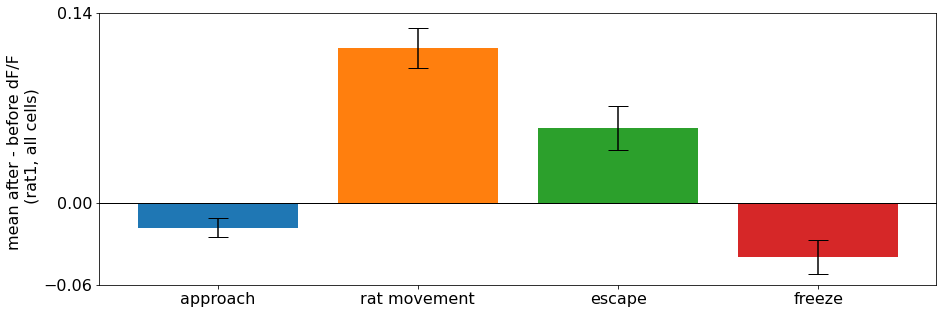

In [14]:
plt.figure(figsize=(15, 5))
for i in range(4):
    diff = np.mean(behavtraces[i][:, 40:59], axis = 1) - np.mean(behavtraces[i][:, 21:40], axis = 1)
    plt.bar(i, np.mean(diff))
    plt.errorbar(i, np.mean(diff), sem(diff), fmt='k_', ms=0, capsize=10)
    print(behavs[i], ttest_1samp(diff, 0))
plt.plot(0, 0, 'k_', ms=2000)
plt.xticks(np.arange(4), behavs)
plt.ylabel('mean after - before dF/F \n (rat1, all cells)')
plt.yticks([-0.06, 0, 0.14])
plt.ylim(-0.06, 0.14)

plt.savefig('./elife_figs/3D.svg')

In [15]:
t = np.arange(-40, 40)/7.5

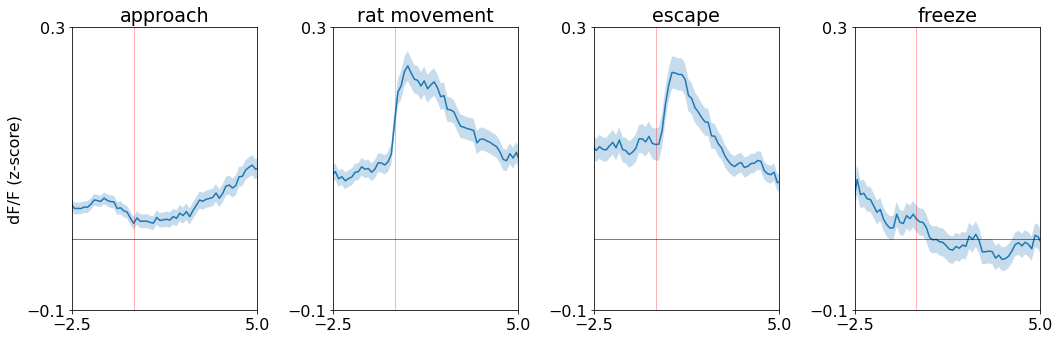

In [16]:
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    if i == 0:
        plt.ylabel('dF/F (z-score)')
    tracemu = np.mean(behavtraces[i], axis=0)
    tracesem = sem(behavtraces[i], axis=0)
    plt.fill_between(t, tracemu-tracesem, tracemu+tracesem, alpha=0.25)
    plt.plot(t, tracemu)
    
    plt.title(behavs[i])
    plt.xlim(-2.5, 5)
    plt.xticks([-2.5, 5])
    plt.plot(0, 0, 'r|', ms=2000, alpha=0.3)
    plt.plot(0, 0, 'k_', ms=2000, alpha=0.5)
    plt.ylim(-0.1, 0.3)
    plt.yticks([-0.1, 0.3])

plt.ylim()
plt.tight_layout()

plt.savefig('./elife_figs/3E.svg')